# Лабораторная работа №4
Левицкий Валентин А-13-22

Вариант №22

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import sqrt, sin, arcsin,array, cos, log, e, pi
from time import time

## Задача 4.1
Найти с точностью $\varepsilon = 10^{-6}$ все корни системы нелинейных уравнений:

$\sin(x_1 + x_2) - 1.2 x_1 - 0.1 = 0;$

$3 x_1^2 + x_2^2 - 1 = 0$

### Решение

Локализуем корни системы уравнений графически.

/tmp/ipykernel_4036314/501552440.py:5: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(1 - 3 * x1**2)
/tmp/ipykernel_4036314/501552440.py:5: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(1 - 3 * x1**2)
/tmp/ipykernel_4036314/501552440.py:9: RuntimeWarning: invalid value encountered in arcsin
  return arcsin(1.2 *x1 + 0.1) - x1


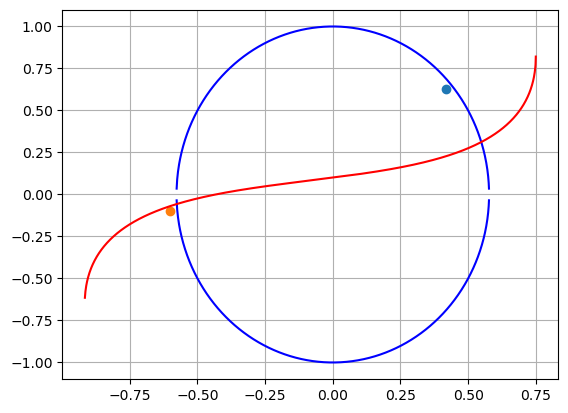

In [6]:
X1 = np.arange(-10, 10, 0.001)
X2 = np.arange(-10, 10, 0.001)

def f2(x1):
    return sqrt(1 - 3 * x1**2)


def f1(x1):
    return arcsin(1.2 *x1 + 0.1) - x1

x0 = array([0.42, 0.63])
x1 = array([-0.6, -0.1])

plt.plot(X1, f2(X1), color='blue')
plt.plot(X1, -f2(X1), color='blue')
plt.plot(X1, f1(X1), color='red')
plt.scatter(*x0)
plt.scatter(*x1)
plt.grid()

Произведем линеаризацию системы. Составим программу-функцию, вычисляющую корень системы двух нелинейных уравнений по упрощенному  методу Ньютона с точностью $\varepsilon$ с подсчетом числа итераций.

In [7]:
def F(X):
    return array([sin(X[0] + X[1]) - 1.2*X[0] - 0.1,
                  3 * X[0] ** 2 + X[1] ** 2 - 1])

def derF(X):
    return array([[cos(X[0] + X[1]) - 1.2, cos(X[0] + X[1])],
                  [6 * X[0], 2 * X[1]]])

def newton(x0):
    eps = 10**(-6)
    n=1
    dF = np.linalg.inv(derF(x0))
    x1 = x0 - dF.dot(F(x0))
    while np.max(np.abs(x1 - x0)) > eps:
        x0 = x1
        x1 = x0 - dF.dot(F(x0))
        n += 1
    print(f"Выполнено итераций: {n}")
    return x1

Найдем корни с заданной точностью.

Выполнено итераций: 1
Выполнено итераций: 1
x0 = array([0.54851816, 0.31206328])
x1 = array([-0.5764198 , -0.05675084])


/tmp/ipykernel_4036314/501552440.py:5: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(1 - 3 * x1**2)
/tmp/ipykernel_4036314/501552440.py:5: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(1 - 3 * x1**2)
/tmp/ipykernel_4036314/501552440.py:9: RuntimeWarning: invalid value encountered in arcsin
  return arcsin(1.2 *x1 + 0.1) - x1


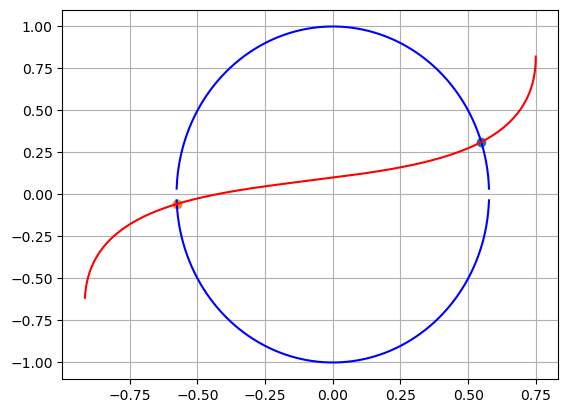

In [9]:
x0 = newton(x0)
x1 = newton(x1)
plt.plot(X1, f2(X1), color='blue')
plt.plot(X1, -f2(X1), color='blue')
plt.plot(X1, f1(X1), color='red')
plt.scatter(*x0)
plt.scatter(*x1)
plt.grid()
print(f"{x0 = }\n{x1 = }")

$x_0 = (0.548518, 0.312063)$

$x_1 = (-0.576420, -0.056751)$

$\varepsilon = 0.000001$

## Задача 4.2
Дана система уравнений $Ax=b$, где  $A$ – симметричная положительно определенная матрица. Найти решение системы с помощью метода релаксации и метода наискорейшего спуска. Сравнить оба метода решения по числу итераций и по времени решения.

$a_{ij} = \dfrac{\ln(i+j)^3}{t}+Ce^{-(i-j)^2},\quad i,j=1 ...m;\ m=10;\ $
$C = 8.1;\ $
$t = m + 0.1N.\ $

_

### Решение

#### Построение системы

Зададим матрицу $A$ при данном значении $m$. Используя встроенную функцию для нахождения собственных чисел матриц, найдем собственные числа матрицы $A$ (убедимся, что матрица $A > 0$).

In [16]:
def gen_mat(m):
    N = 22
    C = 8.1
    t = m + 0.1 * N
    matr = np.zeros((m, m))
    for i in range(1, m+1): 
        for j in range(1, m+1):
            matr[i-1][j-1] = log((i + j)**3) / t + C * e ** (- (i - j)**2)
    return matr

m = 10
A = gen_mat(m)
lambdas, _ = np.linalg.eig(A)
lambdas

array([19.63490567, 13.04283203, 12.08613086, 10.36141118,  8.75983754,
        6.99995211,  5.49114634,  2.633531  ,  3.22827887,  4.18063448])

Матрица положительно определенная.

Зададим вектор с координатами: $x_i = N$ и вектор $b = Ax$

In [17]:
x_root = np.ones(m) * 22
b = A.dot(x_root)

Преобразуем систему к виду удобному для итераций $y = Bx + c$.

In [18]:
def modify(A, b):
    B = np.zeros_like(A)
    c = np.zeros_like(b)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            B[i][j] = 0 if i == j else -A[i][j] / A[i][i]
        c[i] = b[i] / A[i][i]
    return B, c



#### Метод релаксации

Составим программу, реализующую метод релаксации с параметром $\omega$. Изменяя значения параметра $\omega$ из интервала $(0, 2)$ с шагом $0.1$, найдем оптимальное значение параметра.

Выполнено 452 итераций метода релаксации.
Выполнено 224 итераций метода релаксации.
Выполнено 146 итераций метода релаксации.
Выполнено 105 итераций метода релаксации.
Выполнено 81 итераций метода релаксации.
Выполнено 64 итераций метода релаксации.
Выполнено 51 итераций метода релаксации.
Выполнено 42 итераций метода релаксации.
Выполнено 34 итераций метода релаксации.
Выполнено 28 итераций метода релаксации.
Выполнено 23 итераций метода релаксации.
Выполнено 28 итераций метода релаксации.
Выполнено 35 итераций метода релаксации.
Выполнено 43 итераций метода релаксации.
Выполнено 55 итераций метода релаксации.
Выполнено 70 итераций метода релаксации.
Выполнено 96 итераций метода релаксации.
Выполнено 147 итераций метода релаксации.
Выполнено 299 итераций метода релаксации.
Выполнено 23 итераций метода релаксации.
time() - t0 = 0.0010638236999511719
Минимальное число итераций23
Оптимальное omega = 1.1


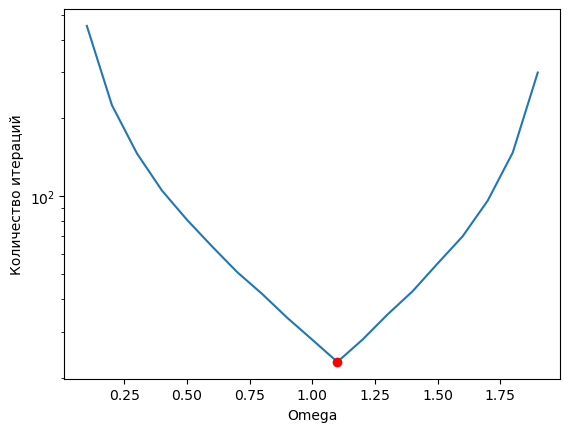

In [19]:
def relax(A, b, eps, omega):
    '''
    SOR method of solving linear system x = Bx + c 
    '''
    B, c = modify(A, b)
    x0 = c.copy()
    r0 = np.max(np.abs(b - A.dot(x0)))
    for n in range(100000):
        x1 = x0.copy()
        for i in range(B.shape[0]):
            s = c[i]
            for j in range(B.shape[1]):
                s += B[i, j] * x1[j]
            
            x1[i] = omega * s + (1 - omega) * x1[i]
        r1 = np.max(np.abs(b - A.dot(x1)))
        # print(r1/ r0)
        x0 = x1
        if r1 / r0 <= eps: break
    # print('ok')
    print(f'Выполнено {n} итераций метода релаксации.')
    return (n, x1)

omegas = [i / 10 for i in range(1, 20)]
iters = [0 for i in range(1, 20)]
for i in range(1, 20):
    omega = i / 10
    iters[i - 1], _ = relax(A, b, 1e-10, omega)

t0 = time()
relax(A, b, 1e-10, 1.1)
print(f'{time() - t0 = }')

min_index = np.argmin(iters)
print(f'Минимальное число итераций{iters[min_index]}')
print(f'Оптимальное omega = {omegas[min_index]}')
plt.plot(omegas, iters)
plt.plot(omegas[min_index], iters[min_index], 'ro')
plt.xlabel('Omega')
plt.ylabel('Количество итераций')
plt.yscale("log")
plt.show()

#### Метод наискорейшего спуска

In [20]:
def gcd(A, b, x, eps):
    x0 = x.copy()
    r0 = b - A.dot(x0)
    started_r0 = np.linalg.norm(r0)
    for n in range(1000):
        Ar = A.dot(r0)
        tau1 = np.linalg.norm(r0)**2 / (Ar.dot(r0))
        r1 = r0 - tau1 * Ar
        # print(f'{n = }\n-------\n{np.linalg.norm(r1) = }\n')
        x1 = x0 + tau1 * r0
        if np.linalg.norm(r1) / started_r0 <= eps:
            break
        r0 = r1
        x0 = x1
    print(f'Выполнено {n} итераций метода наискорейшего спуска.')
    return x1

x = gcd(A, b, b, 1e-10)
x

Выполнено 49 итераций метода наискорейшего спуска.


array([22.00000012, 21.99999982, 22.00000027, 21.99999976, 22.00000024,
       21.99999986, 22.00000012, 21.99999998, 22.00000003, 22.00000002])

#### Размерность 10m 

In [21]:
A_big = gen_mat(100)
x_root_big = np.ones(100) * 22
b_big = A_big.dot(x_root_big)

Решим систему с оптимальным значением параметра $\omega$, найденным в п.2, при размерности системы $10m$. Определим число итераций, требуемых для достижения заданной точности и время решения системы. Критерий окончания: $\dfrac{||r^{(n)}||}{r^{(0)}} \le \varepsilon=10^{-10}.$

In [22]:
t0=time()
x_relax = relax(A_big, b_big, 1e-10, 1.1)
print(f'{time() - t0 = }')
t0=time()
x_gcd = gcd(A_big, b_big, b_big, 1e-10)
print(f'{time() - t0 = }')

Выполнено 33 итераций метода релаксации.
time() - t0 = 0.1795940399169922
Выполнено 57 итераций метода наискорейшего спуска.
time() - t0 = 0.0032083988189697266


Полученные результаты запишем в таблицу:

| Параметр релаксации | Число итераций при $m=10$ методом релаксации | Время решения | Число итераций при $10m=100$ методом релаксации | Время решения | Число итераций при $10m=100$ методом наискорейшего спуска | Время решения |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 1.1 | 23 | 0.001c | 33 | 0.2c | 57 | 0.002c |

## Задача 4.3
Задана функция $f(x)=x\sin(x)$, определенная на отрезке $[-1;1]$. Требуется разложить функцию в ряд Тейлора в окрестности нуля с точностью $\varepsilon=10^{-10}$ и произвести экономизацию полученного степенного ряда.

### Решение

Разложим функцию в ряд Тейлора:
$$
f(x) = \sum_{k=0}^{\infty} c_k x^k,
$$
где
$$
\begin{cases}
    0, & \ k = 2n + 1, \ n \in \mathbb{N} \\
    \dfrac{(-1)^{k/2 + 1}k}{k!}, & \ k = 2n, \ n \in \mathbb{N}
\end{cases}
$$

Определим функцию $S(x,c) = \sum\limits_{k=0}^{n} c_k x^k$, вычисляющую частичную сумму ряда по коэффициентам $c_k$.

In [11]:
def c_k(k):
    return 0 if k % 2 == 1 else (-1)**(k // 2 + 1) * k / math.factorial(k)

def S_n(n):
    def Sn_in(x):
        sum = 0
        for i in range(n + 1):
            sum += c_k(i) * x ** i
        return sum
    return Sn_in

Определим количество слагаемых необходимих для достижения требуемой точности, построив график.

n = 14


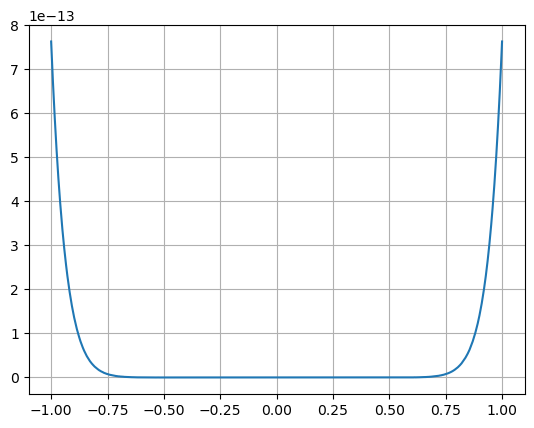

In [14]:
F = lambda x: x * sin(x)
n = 5
x = np.linspace(-1, 1, 1000)
eps = 1e-10

while eps <= max(abs(F(x) - S_n(n)(x))):
    n += 1
print(f"{n = }")

# plt.plot(x, )
plt.plot(x, abs(S_n(n)(x) - F(x)))
plt.grid()

Произведем экономизацию степенного ряда до тех пор, пока сохраняется необходимая точность. Для этого воспользуемся многочленами Чебышёва, которые задаються рекурентным соотношением:
$$
T_0(x) = 1,\ T_1(x) = x,\ T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)
$$
Вычеслим первые 14 многочленов Чебышёва.

In [13]:
def get_Ts_to(n):
    T = [[1], [0, 1]]
    for i in range(2, n + 1,):
        T.append([0] * (i + 1))
        for j in range(i):
            T[i][j + 1] = 2 * T[i - 1][j]
        for j in range(i - 1):
            T[i][j] -= T[i - 2][j]
    return T

Ts = get_Ts_to(14)
for i in range(len(Ts)):
    print(f"T{i:<2}: {Ts[i]}")

T0 : [1]
T1 : [0, 1]
T2 : [-1, 0, 2]
T3 : [0, -3, 0, 4]
T4 : [1, 0, -8, 0, 8]
T5 : [0, 5, 0, -20, 0, 16]
T6 : [-1, 0, 18, 0, -48, 0, 32]
T7 : [0, -7, 0, 56, 0, -112, 0, 64]
T8 : [1, 0, -32, 0, 160, 0, -256, 0, 128]
T9 : [0, 9, 0, -120, 0, 432, 0, -576, 0, 256]
T10: [-1, 0, 50, 0, -400, 0, 1120, 0, -1280, 0, 512]
T11: [0, -11, 0, 220, 0, -1232, 0, 2816, 0, -2816, 0, 1024]
T12: [1, 0, -72, 0, 840, 0, -3584, 0, 6912, 0, -6144, 0, 2048]
T13: [0, 13, 0, -364, 0, 2912, 0, -9984, 0, 16640, 0, -13312, 0, 4096]
T14: [-1, 0, 98, 0, -1568, 0, 9408, 0, -26880, 0, 39424, 0, -28672, 0, 8192]


Запишем частичную сумму ряда, для $k = 14$
$$
S_{14}(x) = \frac{1}{2}x^2 - \frac{1}{4!}x^4 + \frac{1}{6!}x^6 - \frac{1}{8!}x^{8} + \frac{1}{10!}x^{10} - \frac{1}{12!}x^{12} + \frac{1}{14!}x^{14}
$$

Построим график погрешности каждого этапа экономизации.

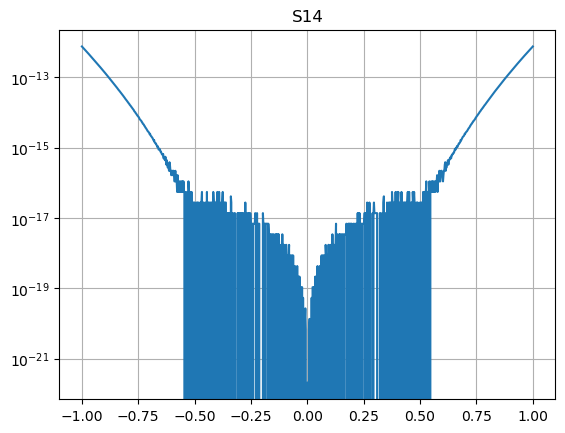

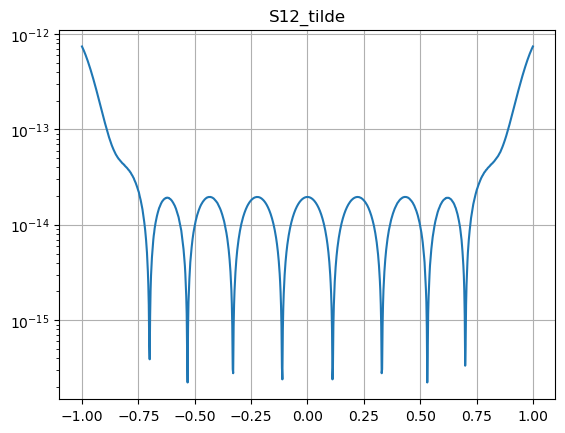

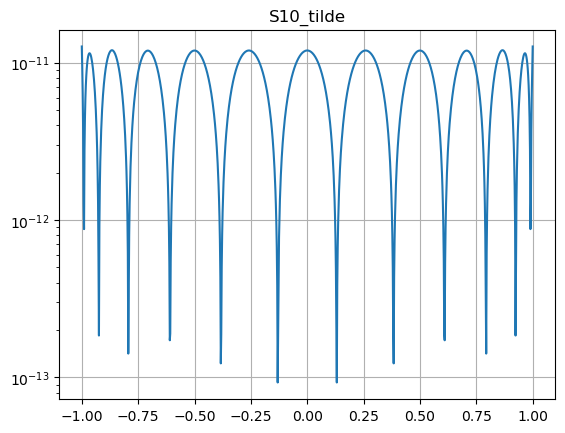

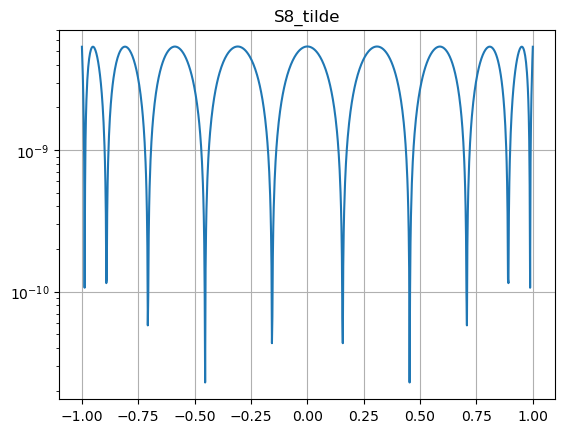

In [15]:
x14 = lambda x: 1 / 8192 * (28672 * x ** 12 - 39424 * x ** 10 + 26880 * x ** 8 - 9408 * x ** 6 + 1568 * x ** 4 - 98 * x ** 2 + 1)
S14 = S_n(14)
S12_tilde = lambda x: S_n(12)(x) + c_k(14) * x14(x)
x12 = lambda x: 1 / 2048 * (6144 * x ** 10 - 6912 * x ** 8 + 3584 * x ** 6 - 840 * x ** 4 + 72 * x ** 2 - 1)
x14_12 = lambda x: 1 / 8192 * (28672 * x12(x) - 39424 * x ** 10 + 26880 * x ** 8 - 9408 * x ** 6 + 1568 * x ** 4 - 98 * x ** 2 + 1)
S10_tilde = lambda x: S_n(10)(x) + c_k(12) * x12(x) + c_k(14) * x14_12(x) 
x10 = lambda x: 1 / 512 * (1280 * x ** 8 - 1120 * x ** 6 + 400 * x ** 4 - 50 * x ** 2 + 1)
x12_10 =  lambda x: 1 / 2048 * (6144 * x10(x) ** 10 - 6912 * x ** 8 + 3584 * x ** 6 - 840 * x ** 4 + 72 * x ** 2 - 1)
x14_12_10 = lambda x: 1 / 8192 * (28672 * x12(x) - 39424 * x10(x) ** 10 + 26880 * x ** 8 - 9408 * x ** 6 + 1568 * x ** 4 - 98 * x ** 2 + 1)
S8_tilde = lambda x: S_n(8)(x)+ c_k(10) * x10(x) + c_k(12) * x12(x) + c_k(14) * x14_12(x) 

plt.plot(x, abs(F(x) - S14(x)))
plt.title("S14")
plt.yscale("log")
plt.grid()
plt.show()
plt.plot(x, abs(F(x) - S12_tilde(x)))
plt.title("S12_tilde")
plt.yscale("log")
plt.grid()
plt.show()
plt.plot(x, abs(F(x) - S10_tilde(x)))
plt.title("S10_tilde")
plt.yscale("log")
plt.grid()
plt.show()
plt.plot(x, abs(F(x) - S8_tilde(x)))
plt.title("S8_tilde")
plt.yscale("log")
plt.grid()
plt.show()